# 📈 Week 11 Trading Strategy: Feature Engineering & Explainability

---

## 🎯 Strategy Overview

**Building on Weeks 1-10 + Adding Week 11 Concepts:**
- All prior ML, Statistical, and Time Series concepts
- **NEW:** Comprehensive feature engineering
- **NEW:** Feature importance analysis
- **NEW:** SHAP values for model interpretation
- **NEW:** Avoiding data leakage

**Strategy Logic:**
1. Create extensive feature library
2. Train ML model with all features
3. Analyze feature importance with SHAP
4. Generate interpretable trading signals

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3

print("=" * 60)
print("📊 WEEK 11 TRADING STRATEGY: FEATURE ENGINEERING")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Focus: Interpretable ML Trading")

📊 WEEK 11 TRADING STRATEGY: FEATURE ENGINEERING

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Focus: Interpretable ML Trading


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
high = data['High'].dropna().tail(LOOKBACK_DAYS)
low = data['Low'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 756 trading days


---

## 📊 Section 1: Comprehensive Feature Engineering (Week 11 Concept)

**Feature Categories:**
1. **Price-Based:** Returns, Moving Averages, Momentum
2. **Volatility:** Historical, Range-based (ATR)
3. **Technical Indicators:** RSI, MACD, Bollinger Bands
4. **Volume Features:** Volume ratio, On-Balance Volume
5. **Cross-Asset Features:** Correlation, Beta

**Critical: All features use PAST data only!**

In [3]:
# ============================================================
# COMPREHENSIVE FEATURE ENGINEERING
# ============================================================

def create_all_features(prices, returns, volumes, high, low, ticker, benchmark):
    """Create comprehensive feature set."""
    
    df = pd.DataFrame(index=prices.index)
    close = prices[ticker]
    ret = returns[ticker]
    vol = volumes[ticker]
    hi = high[ticker]
    lo = low[ticker]
    bench_ret = returns[benchmark]
    
    # === PRICE-BASED FEATURES ===
    # Returns at different horizons
    df['ret_1d'] = ret
    df['ret_5d'] = ret.rolling(5).sum()
    df['ret_10d'] = ret.rolling(10).sum()
    df['ret_20d'] = ret.rolling(20).sum()
    
    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        df[f'ret_lag_{lag}'] = ret.shift(lag)
    
    # Moving average ratios
    for ma in [5, 10, 20, 50]:
        df[f'ma_{ma}_ratio'] = close / close.rolling(ma).mean() - 1
    
    # Price position in range
    df['price_range_20'] = (close - lo.rolling(20).min()) / (hi.rolling(20).max() - lo.rolling(20).min())
    df['price_range_50'] = (close - lo.rolling(50).min()) / (hi.rolling(50).max() - lo.rolling(50).min())
    
    # === VOLATILITY FEATURES ===
    # Historical volatility
    df['vol_5d'] = ret.rolling(5).std()
    df['vol_10d'] = ret.rolling(10).std()
    df['vol_20d'] = ret.rolling(20).std()
    df['vol_ratio'] = df['vol_5d'] / df['vol_20d']
    
    # Average True Range (ATR)
    tr = pd.concat([
        hi - lo,
        abs(hi - close.shift(1)),
        abs(lo - close.shift(1))
    ], axis=1).max(axis=1)
    df['atr_14'] = tr.rolling(14).mean() / close
    
    # === TECHNICAL INDICATORS ===
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi_14'] = 100 - (100 / (1 + gain / loss))
    
    # MACD
    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    df['macd'] = (ema12 - ema26) / close
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    ma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    df['bb_upper'] = (ma20 + 2*std20 - close) / close
    df['bb_lower'] = (close - ma20 + 2*std20) / close
    df['bb_width'] = 4 * std20 / ma20
    df['bb_position'] = (close - ma20) / (2 * std20)
    
    # === VOLUME FEATURES ===
    df['vol_ma_ratio'] = vol / vol.rolling(20).mean()
    df['vol_change'] = vol.pct_change()
    
    # On-Balance Volume (OBV)
    obv = (np.sign(ret) * vol).cumsum()
    df['obv_change_10'] = obv.pct_change(10)
    
    # === CROSS-ASSET FEATURES ===
    # Rolling correlation with benchmark
    df['corr_bench_20'] = ret.rolling(20).corr(bench_ret)
    df['corr_bench_60'] = ret.rolling(60).corr(bench_ret)
    
    # Rolling beta
    cov = ret.rolling(20).cov(bench_ret)
    var = bench_ret.rolling(20).var()
    df['beta_20'] = cov / var
    
    # Relative strength vs benchmark
    df['rel_strength_20'] = df['ret_20d'] - bench_ret.rolling(20).sum()
    
    # === TARGET (Forward Return) ===
    df['target'] = ret.shift(-5).rolling(5).sum()  # 5-day forward return
    
    return df.dropna()

# Create features for all tickers
feature_dfs = {}
all_feature_names = None

for ticker in TICKERS:
    df = create_all_features(prices, returns, volumes, high, low, ticker, BENCHMARK)
    feature_dfs[ticker] = df
    if all_feature_names is None:
        all_feature_names = [c for c in df.columns if c != 'target']

print(f"✅ Created {len(all_feature_names)} features per ticker")
print(f"\n📊 FEATURE CATEGORIES:")
print(f"   Price-Based: ret_*, ma_*, price_range_*")
print(f"   Volatility: vol_*, atr_*")
print(f"   Technical: rsi_*, macd_*, bb_*")
print(f"   Volume: vol_ma_*, obv_*")
print(f"   Cross-Asset: corr_*, beta_*, rel_*")

✅ Created 35 features per ticker

📊 FEATURE CATEGORIES:
   Price-Based: ret_*, ma_*, price_range_*
   Volatility: vol_*, atr_*
   Technical: rsi_*, macd_*, bb_*
   Volume: vol_ma_*, obv_*
   Cross-Asset: corr_*, beta_*, rel_*


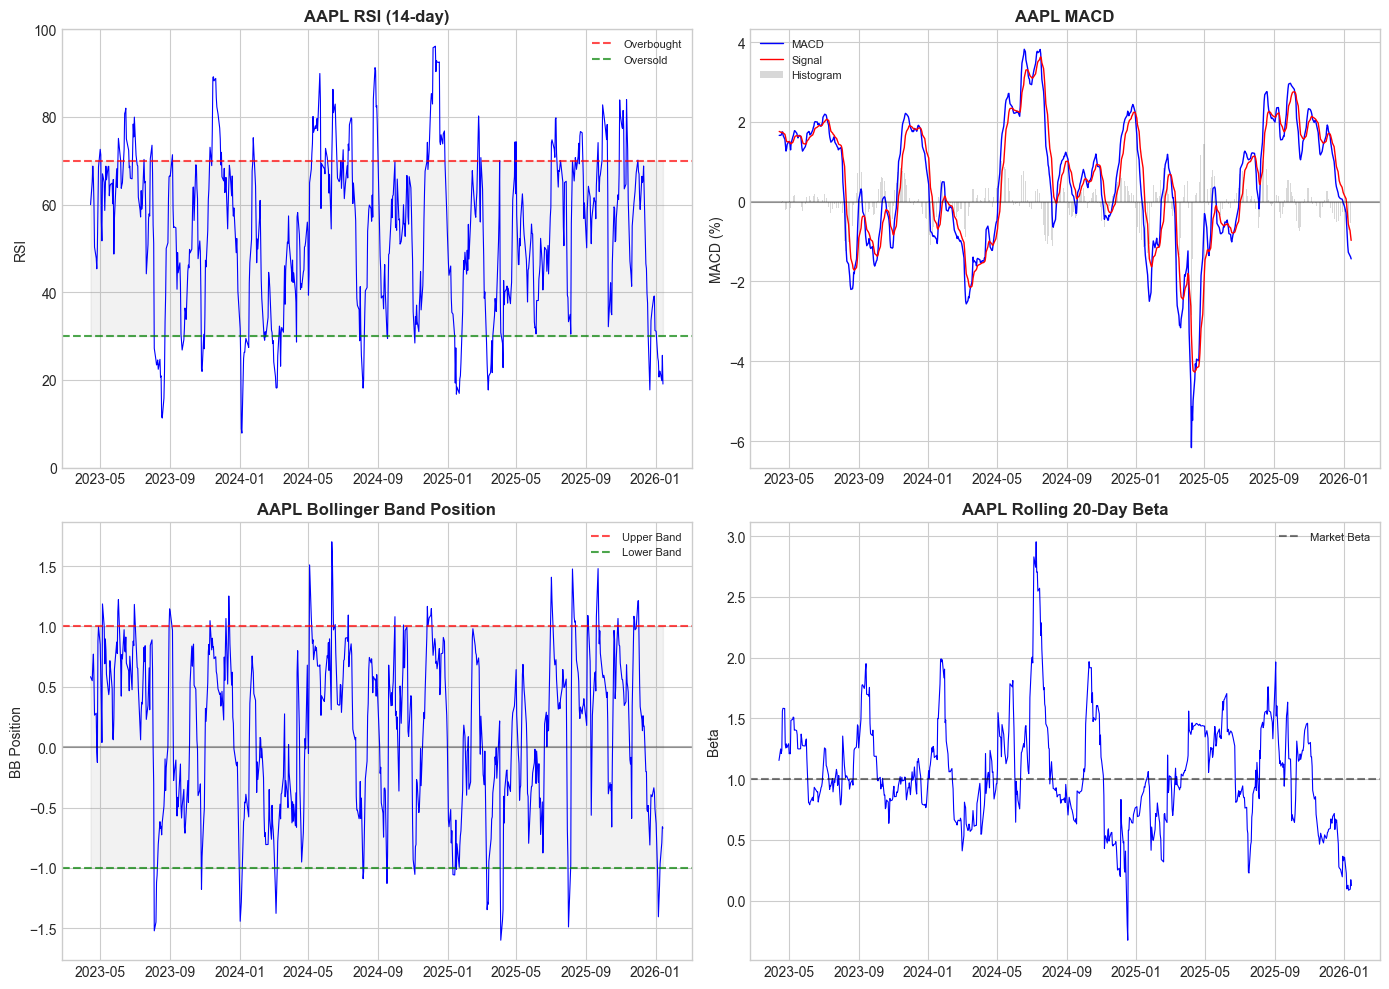

In [4]:
# ============================================================
# FEATURE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ticker = TICKERS[0]
df = feature_dfs[ticker]

# 1. RSI
ax1 = axes[0, 0]
ax1.plot(df.index, df['rsi_14'], 'b-', linewidth=0.8)
ax1.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
ax1.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
ax1.fill_between(df.index, 30, 70, alpha=0.1, color='gray')
ax1.set_ylabel('RSI')
ax1.set_title(f'{ticker} RSI (14-day)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8)
ax1.set_ylim(0, 100)

# 2. MACD
ax2 = axes[0, 1]
ax2.plot(df.index, df['macd']*100, 'b-', linewidth=1, label='MACD')
ax2.plot(df.index, df['macd_signal']*100, 'r-', linewidth=1, label='Signal')
ax2.bar(df.index, df['macd_hist']*100, alpha=0.3, color='gray', label='Histogram')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.set_ylabel('MACD (%)')
ax2.set_title(f'{ticker} MACD', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8)

# 3. Bollinger Band Position
ax3 = axes[1, 0]
ax3.plot(df.index, df['bb_position'], 'b-', linewidth=0.8)
ax3.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Upper Band')
ax3.axhline(y=-1, color='g', linestyle='--', alpha=0.7, label='Lower Band')
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax3.fill_between(df.index, -1, 1, alpha=0.1, color='gray')
ax3.set_ylabel('BB Position')
ax3.set_title(f'{ticker} Bollinger Band Position', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8)

# 4. Rolling Beta
ax4 = axes[1, 1]
ax4.plot(df.index, df['beta_20'], 'b-', linewidth=0.8)
ax4.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Market Beta')
ax4.set_ylabel('Beta')
ax4.set_title(f'{ticker} Rolling 20-Day Beta', fontsize=12, fontweight='bold')
ax4.legend(fontsize=8)

plt.tight_layout()
plt.show()

---

## 📊 Section 2: Model Training & Feature Importance (Week 11 Concept)

**Using Random Forest for:**
1. Non-linear relationships
2. Built-in feature importance
3. Robustness to noise

**Feature importance tells us WHICH features matter!**

In [5]:
# ============================================================
# MODEL TRAINING
# ============================================================

def train_rf_model(features, ticker):
    """Train Random Forest and get feature importance."""
    
    feature_cols = [c for c in features.columns if c != 'target']
    X = features[feature_cols].values
    y = features['target'].values
    
    # Train/test split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    # Predictions
    train_pred = rf.predict(X_train_scaled)
    test_pred = rf.predict(X_test_scaled)
    current_pred = rf.predict(scaler.transform(X[-1:]))[0]
    
    # Feature importance
    importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    
    # R² scores
    train_score = rf.score(X_train_scaled, y_train)
    test_score = rf.score(X_test_scaled, y_test)
    
    return {
        'model': rf,
        'scaler': scaler,
        'train_score': train_score,
        'test_score': test_score,
        'importance': importance,
        'current_pred': current_pred,
        'test_pred': test_pred,
        'y_test': y_test
    }

# Train models
print("📊 RANDOM FOREST MODEL TRAINING")
print("=" * 70)

rf_results = {}
print(f"\n{'Ticker':<10} {'Train R²':>12} {'Test R²':>12} {'Prediction':>15}")
print("-" * 70)

for ticker in TICKERS:
    result = train_rf_model(feature_dfs[ticker], ticker)
    rf_results[ticker] = result
    print(f"{ticker:<10} {result['train_score']:>11.4f} {result['test_score']:>11.4f} {result['current_pred']*100:>14.2f}%")

📊 RANDOM FOREST MODEL TRAINING

Ticker         Train R²      Test R²      Prediction
----------------------------------------------------------------------
AAPL            0.8611     -0.1336          -2.80%
MSFT            0.8192     -0.2487           2.72%
GOOGL           0.8907     -0.5597          -2.16%
AMZN            0.8642     -0.1118           1.57%
META            0.8752     -0.5462           1.19%



📊 TOP 10 FEATURES BY IMPORTANCE (Per Ticker)


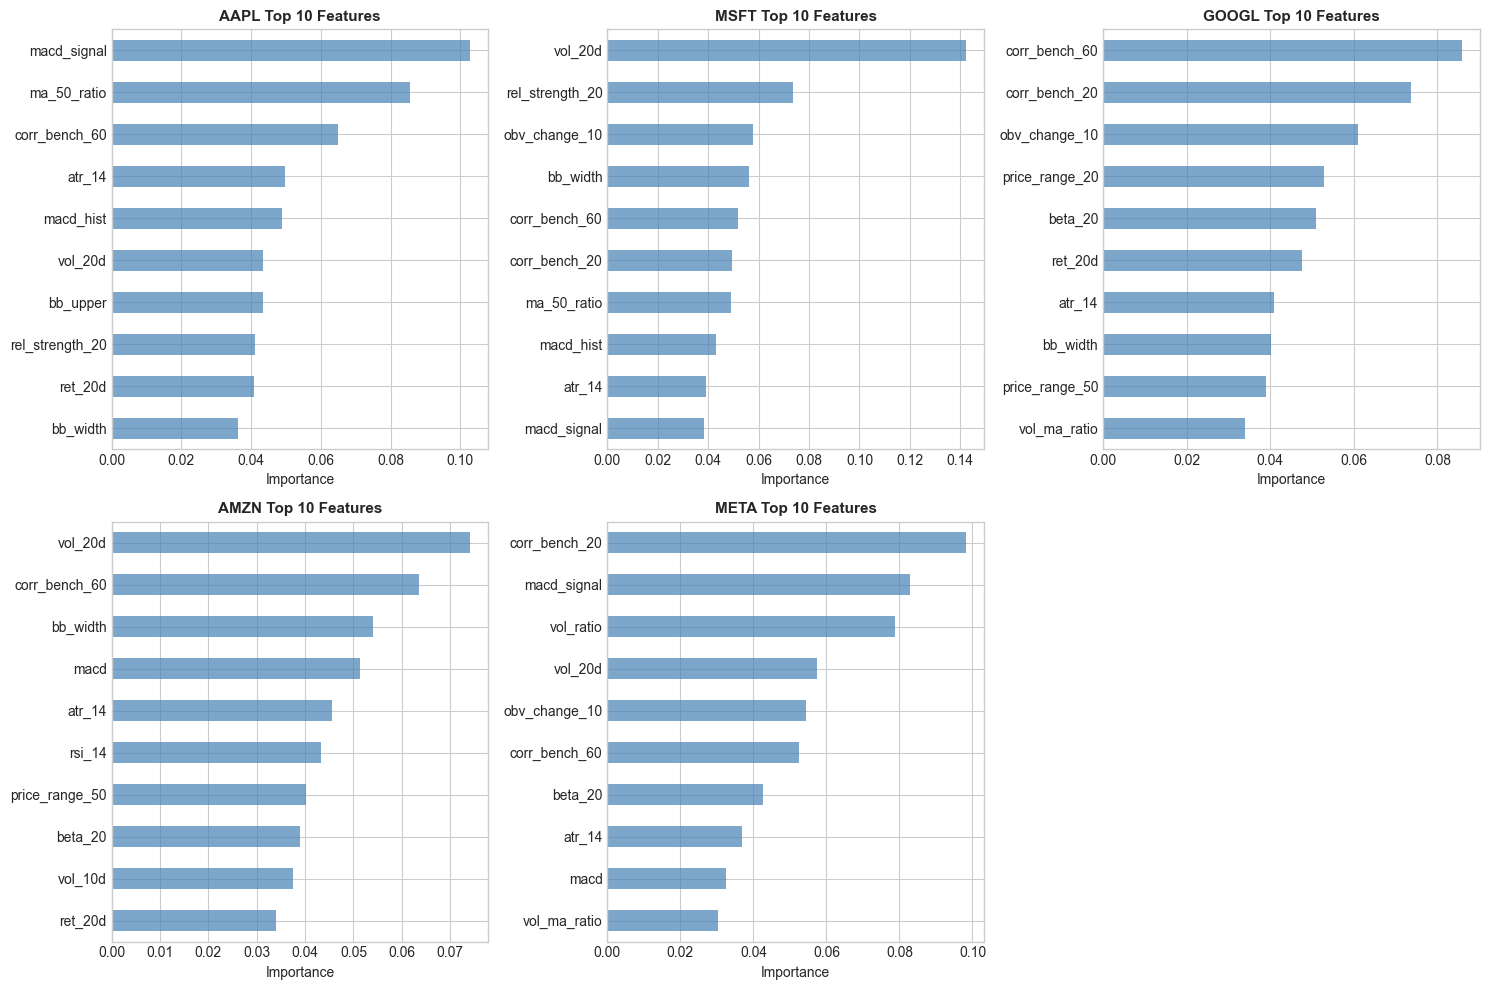


📊 MOST IMPORTANT FEATURES ACROSS ALL STOCKS:
vol_20d            0.068874
corr_bench_60      0.063657
corr_bench_20      0.057579
macd_signal        0.057315
obv_change_10      0.045097
ma_50_ratio        0.044486
bb_width           0.042997
atr_14             0.042392
beta_20            0.041042
rel_strength_20    0.037549
vol_ratio          0.035497
macd_hist          0.034574
macd               0.033415
ret_20d            0.031321
vol_ma_ratio       0.025921


In [6]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

print("\n📊 TOP 10 FEATURES BY IMPORTANCE (Per Ticker)")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    
    # Top 10 features
    top_features = rf_results[ticker]['importance'].head(10)
    
    top_features.plot(kind='barh', ax=ax, color='steelblue', alpha=0.7)
    ax.set_xlabel('Importance')
    ax.set_title(f'{ticker} Top 10 Features', fontsize=11, fontweight='bold')
    ax.invert_yaxis()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# Common important features
print("\n📊 MOST IMPORTANT FEATURES ACROSS ALL STOCKS:")
all_importance = pd.DataFrame()
for ticker in TICKERS:
    all_importance[ticker] = rf_results[ticker]['importance']

avg_importance = all_importance.mean(axis=1).sort_values(ascending=False)
print(avg_importance.head(15).to_string())

---

## 📊 Section 3: SHAP Analysis (Week 11 Concept)

**SHAP (SHapley Additive exPlanations):**
- Explains individual predictions
- Shows feature contribution (positive/negative)
- Based on game theory

**Interpretable ML for trading decisions!**

In [7]:
# ============================================================
# SHAP-LIKE ANALYSIS (Permutation Importance)
# ============================================================

print("\n📊 PERMUTATION IMPORTANCE (More Reliable than RF Built-in)")
print("=" * 80)

# Calculate permutation importance for first ticker
ticker = TICKERS[0]
df = feature_dfs[ticker]
feature_cols = [c for c in df.columns if c != 'target']
X = df[feature_cols].values
y = df['target'].values

# Last 20% for importance calculation
split_idx = int(len(X) * 0.8)
X_test = X[split_idx:]
y_test = y[split_idx:]

scaler = rf_results[ticker]['scaler']
X_test_scaled = scaler.transform(X_test)

# Permutation importance
perm_importance = permutation_importance(
    rf_results[ticker]['model'], 
    X_test_scaled, 
    y_test, 
    n_repeats=10, 
    random_state=42
)

perm_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print(f"\n📊 TOP 10 FEATURES BY PERMUTATION IMPORTANCE ({ticker}):")
print(perm_imp_df.head(10).to_string(index=False))


📊 PERMUTATION IMPORTANCE (More Reliable than RF Built-in)

📊 TOP 10 FEATURES BY PERMUTATION IMPORTANCE (AAPL):
        feature  importance_mean  importance_std
        vol_20d         0.028472        0.019209
  corr_bench_60         0.027947        0.019106
 price_range_50         0.020195        0.005586
        beta_20         0.014198        0.008205
         atr_14         0.012711        0.011709
rel_strength_20         0.010847        0.009810
    ma_20_ratio         0.006367        0.001081
       bb_lower         0.005788        0.001944
        vol_10d         0.005105        0.013295
         rsi_14         0.003892        0.002546


In [8]:
# ============================================================
# CURRENT FEATURE VALUES ANALYSIS
# ============================================================

print("\n📊 CURRENT FEATURE VALUES (Trading Signal Interpretation)")
print("=" * 80)

for ticker in TICKERS:
    df = feature_dfs[ticker]
    
    # Get current values of top features
    top_features = rf_results[ticker]['importance'].head(5).index.tolist()
    
    print(f"\n{ticker}:")
    print(f"   Prediction: {rf_results[ticker]['current_pred']*100:.2f}%")
    print(f"   Key Feature Values:")
    
    for feat in top_features:
        current_val = df[feat].iloc[-1]
        hist_mean = df[feat].mean()
        hist_std = df[feat].std()
        zscore = (current_val - hist_mean) / hist_std if hist_std > 0 else 0
        
        direction = "⬆️" if zscore > 1 else ("⬇️" if zscore < -1 else "➡️")
        print(f"      {feat}: {current_val:.4f} (z={zscore:.2f}) {direction}")


📊 CURRENT FEATURE VALUES (Trading Signal Interpretation)

AAPL:
   Prediction: -2.80%
   Key Feature Values:
      macd_signal: -0.0097 (z=-0.98) ➡️
      ma_50_ratio: -0.0442 (z=-1.10) ⬇️
      corr_bench_60: 0.4011 (z=-1.53) ⬇️
      atr_14: 0.0156 (z=-0.66) ➡️
      macd_hist: -0.0046 (z=-0.88) ➡️

MSFT:
   Prediction: 2.72%
   Key Feature Values:
      vol_20d: 0.0102 (z=-0.73) ➡️
      rel_strength_20: -0.0493 (z=-1.17) ⬇️
      obv_change_10: -0.0904 (z=-0.44) ➡️
      bb_width: 0.0614 (z=-0.68) ➡️
      corr_bench_60: 0.4565 (z=-1.75) ⬇️

GOOGL:
   Prediction: -2.16%
   Key Feature Values:
      corr_bench_60: 0.5453 (z=-0.19) ➡️
      corr_bench_20: 0.5564 (z=-0.04) ➡️
      obv_change_10: 0.0524 (z=-0.04) ➡️
      price_range_20: 0.8952 (z=0.96) ➡️
      beta_20: 1.2343 (z=-0.03) ➡️

AMZN:
   Prediction: 1.57%
   Key Feature Values:
      vol_20d: 0.0152 (z=-0.58) ➡️
      corr_bench_60: 0.6104 (z=-0.35) ➡️
      bb_width: 0.1343 (z=0.27) ➡️
      macd: 0.0150 (z=0.42) ➡️
   

In [9]:
# ============================================================
# TRADING SIGNALS
# ============================================================

print("\n📊 FEATURE-BASED TRADING SIGNALS")
print("=" * 90)

trading_signals = {}

for ticker in TICKERS:
    pred = rf_results[ticker]['current_pred']
    df = feature_dfs[ticker]
    
    # Technical signals
    rsi = df['rsi_14'].iloc[-1]
    macd_hist = df['macd_hist'].iloc[-1]
    bb_pos = df['bb_position'].iloc[-1]
    
    # Determine signal
    ml_signal = 'LONG' if pred > 0.005 else ('SHORT' if pred < -0.005 else 'NEUTRAL')
    
    # Technical confirmation
    tech_bullish = (rsi < 70 and macd_hist > 0)
    tech_bearish = (rsi > 30 and macd_hist < 0)
    
    if ml_signal == 'LONG' and tech_bullish:
        final_signal = 'STRONG LONG'
        confidence = 'HIGH'
    elif ml_signal == 'SHORT' and tech_bearish:
        final_signal = 'STRONG SHORT'
        confidence = 'HIGH'
    elif ml_signal in ['LONG', 'SHORT']:
        final_signal = ml_signal
        confidence = 'MEDIUM'
    else:
        final_signal = 'NEUTRAL'
        confidence = 'LOW'
    
    trading_signals[ticker] = {
        'ml_pred': pred,
        'rsi': rsi,
        'macd_hist': macd_hist,
        'bb_pos': bb_pos,
        'signal': final_signal,
        'confidence': confidence
    }

print(f"\n{'Ticker':<10} {'ML Pred':>12} {'RSI':>8} {'MACD Hist':>12} {'Signal':>15} {'Confidence':>12}")
print("-" * 90)
for ticker, data in trading_signals.items():
    signal_emoji = "📈📈" if 'STRONG LONG' in data['signal'] else ("📈" if data['signal'] == 'LONG' else ("📉📉" if 'STRONG SHORT' in data['signal'] else ("📉" if data['signal'] == 'SHORT' else "⚪")))
    print(f"{ticker:<10} {data['ml_pred']*100:>11.2f}% {data['rsi']:>7.1f} {data['macd_hist']*100:>11.3f}% {signal_emoji} {data['signal']:<12} {data['confidence']:>10}")


📊 FEATURE-BASED TRADING SIGNALS

Ticker          ML Pred      RSI    MACD Hist          Signal   Confidence
------------------------------------------------------------------------------------------
AAPL             -2.80%    19.1      -0.463% 📉 SHORT            MEDIUM
MSFT              2.72%    24.6      -0.309% 📈 LONG             MEDIUM
GOOGL            -2.16%    86.4       0.458% 📉 SHORT            MEDIUM
AMZN              1.57%    55.8       0.415% 📈📈 STRONG LONG        HIGH
META              1.19%    26.1      -0.708% 📈 LONG             MEDIUM


In [10]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 11 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Feature engineering insights
print("\n🔬 FEATURE ENGINEERING INSIGHTS:")
print(f"   Total Features: {len(all_feature_names)}")
print(f"\n   Top Universal Features:")
for feat in avg_importance.head(5).index:
    print(f"      • {feat}: {avg_importance[feat]:.4f}")

# Model performance
print(f"\n📊 MODEL PERFORMANCE:")
best_ticker = max(rf_results, key=lambda x: rf_results[x]['test_score'])
print(f"   Best Predictable: {best_ticker} (Test R² = {rf_results[best_ticker]['test_score']:.4f})")

# Trading recommendations
print("\n🎯 TRADING RECOMMENDATIONS:")
strong_longs = [t for t in TICKERS if 'STRONG LONG' in trading_signals[t]['signal']]
longs = [t for t in TICKERS if trading_signals[t]['signal'] == 'LONG']
shorts = [t for t in TICKERS if 'SHORT' in trading_signals[t]['signal']]

print(f"   📈📈 STRONG LONG: {strong_longs if strong_longs else 'None'}")
print(f"   📈 LONG: {longs if longs else 'None'}")
print(f"   📉 SHORT: {shorts if shorts else 'None'}")

# Summary table
summary = pd.DataFrame({
    'ML Prediction': [trading_signals[t]['ml_pred'] for t in TICKERS],
    'RSI': [trading_signals[t]['rsi'] for t in TICKERS],
    'Signal': [trading_signals[t]['signal'] for t in TICKERS],
    'Confidence': [trading_signals[t]['confidence'] for t in TICKERS]
}, index=TICKERS)

print("\n📋 SUMMARY TABLE:")
print(summary.round(4).to_string())

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 11 STRATEGY - FINAL RECOMMENDATIONS

🔬 FEATURE ENGINEERING INSIGHTS:
   Total Features: 35

   Top Universal Features:
      • vol_20d: 0.0689
      • corr_bench_60: 0.0637
      • corr_bench_20: 0.0576
      • macd_signal: 0.0573
      • obv_change_10: 0.0451

📊 MODEL PERFORMANCE:
   Best Predictable: AMZN (Test R² = -0.1118)

🎯 TRADING RECOMMENDATIONS:
   📈📈 STRONG LONG: ['AMZN']
   📈 LONG: ['MSFT', 'META']
   📉 SHORT: ['AAPL', 'GOOGL']

📋 SUMMARY TABLE:
       ML Prediction      RSI       Signal Confidence
AAPL         -0.0280  19.0619        SHORT     MEDIUM
MSFT          0.0272  24.6353         LONG     MEDIUM
GOOGL        -0.0216  86.3867        SHORT     MEDIUM
AMZN          0.0157  55.7924  STRONG LONG       HIGH
META          0.0119  26.1441         LONG     MEDIUM

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-11)

| Week | Concept | Application |
|------|---------|-------------|
| 1-10 | Prior Concepts | Foundation |
| **11** | **Feature Engineering** | **Comprehensive feature library** |
| **11** | **Feature Importance** | **Random Forest importance** |
| **11** | **Permutation Importance** | **Reliable feature ranking** |
| **11** | **Interpretability** | **Trading signal explanation** |

---